## 📈 Bitcoin Price Forecasting using LSTM

This notebook presents a deep learning approach to forecast the BTC/USD exchange rate using a Long Short-Term Memory (LSTM) network. 

We follow these main steps:
- Load and preprocess historical Bitcoin prices
- Normalize the time series
- Prepare the data for supervised learning
- Train an LSTM model
- Evaluate and visualize the predictions

The dataset spans from February 2012 to December 2024 and was collected from Investing.com.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Warnings
import warnings
warnings.filterwarnings('ignore')

## 📥 Step 1: Load and Prepare the Dataset

We load the BTC/USD historical data, clean and format it, and set the `Date` column as the index for time series analysis            .

In [28]:
data_btc_usd = pd.read_csv('../data/BTC_USD.csv')
data_btc_usd["Date"] = pd.to_datetime(data_btc_usd["Date"], errors="coerce")
data_btc_usd = data_btc_usd.sort_values("Date")
data_btc_usd.rename(columns={"Price": "BTC-USD"}, inplace=True)
data_btc_usd["BTC-USD"] = data_btc_usd["BTC-USD"].replace({r'\,':''}, regex=True).astype(float)
data_btc_usd.to_csv("../data/BTC-USD.csv", index=False)
data_btc_usd.set_index('Date', inplace=True)
data_btc_usd

,BTC-USD
Date,
2012-02-02,6.1
2012-02-03,6.0
2012-02-04,5.9
2012-02-05,5.7
2012-02-06,5.4
...,...
2024-12-27,94419.0
2024-12-28,95533.0
2024-12-29,93944.0


## 🔍 Step 2: Explore the Dataset

Let's check the structure and summary statistics to understand the data better.

In [29]:
data_btc_usd.info()
data_btc_usd.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4713 entries, 2012-02-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTC-USD  4713 non-null   float64
dtypes: float64(1)
memory usage: 73.6 KB


,BTC-USD
count,4713.000000
mean,15669.225355
std,21243.568499
min,4.200000
25%,422.400000
50%,6490.100000
75%,25870.000000
max,105990.000000


## ⚖️ Step 3: Normalize the Data

To improve LSTM performance, we normalize prices using MinMaxScaler in the [0, 1] range.

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_btc_usd['BTC-USD'].values.reshape(-1, 1))
print(data_scaled[:5])

[[1.79269298e-05]
 [1.69834072e-05]
 [1.60398846e-05]
 [1.41528393e-05]
 [1.13222715e-05]]


## ✂️ Step 4: Train-Test Split

We divide the data into 80% training and 20% testing to evaluate performance on unseen data.

In [31]:
train_size = int(len(data_scaled) * 0.80)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

print(f"Taille des données d'entraînement : {len(train_data)}")
print(f"Taille des données de test : {len(test_data)}")

Taille des données d'entraînement : 3770
Taille des données de test : 943


## 🔁 Step 5: Create Input Sequences

We use a sliding window technique to generate input/output pairs for the LSTM model.  
Here, we use `look_back = 1`, meaning the model will use the current value to predict the next one.

In [32]:
def get_data(data, look_back):
    datax, datay = [], []
    for i in range(len(data) - look_back - 1):
        datax.append(data[i:(i + look_back), 0])
        datay.append(data[i + look_back, 0])
    return np.array(datax), np.array(datay)

In [33]:
look_back = 1
x_train, y_train = get_data(train_data, look_back)
x_test, y_test = get_data(test_data, look_back)

## 🔄 Step 6: Reshape Data

We reshape the data to match LSTM’s expected input format: `(samples, time_steps, features)`.

In [34]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## 🧠 Step 7: Build the LSTM Model

We build a simple yet powerful LSTM model with:
- 100 units
- Sigmoid activation
- Dropout for regularization

In [35]:
n_features = x_train.shape[1]
model = Sequential()
model.add(LSTM(100, activation='sigmoid', input_shape=(1, 1)))
model.add(Dense(n_features))
model.add(Dropout(0.002))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

## ⚙️ Step 8: Compile and Train the Model

We use the Adam optimizer and Mean Squared Error (MSE) as the loss function.
Training uses EarlyStopping to avoid overfitting.

In [36]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[EarlyStopping(patience=3)])

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0282 - val_loss: 0.1017
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0771
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0538
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0421
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0268
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0151
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2154e-04 - val_loss: 0.0027
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9302e-04 - val_loss: 9.6689e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5451e-04 - val_loss: 5.0297e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

## 🔍 Step 9: Make Predictions and Invert Scaling

After training, we predict BTC/USD prices on the test set and revert normalization to interpret results.

In [37]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)

#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

print(y_pred[:10])
print(y_test[:10])

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[29672.543]
 [29819.18 ]
 [29865.465]
 [31309.48 ]
 [31088.049]
 [30171.34 ]
 [30053.82 ]
 [29047.025]
 [28370.61 ]
 [26619.545]]
[[29877. ]
 [29923.4]
 [31371. ]
 [31149. ]
 [30230. ]
 [30112.2]
 [29103. ]
 [28425. ]
 [26670. ]
 [22487. ]]


## 📊 Step 10: Visualize Results

We plot actual vs predicted BTC/USD prices to evaluate visually the performance of our LSTM model.

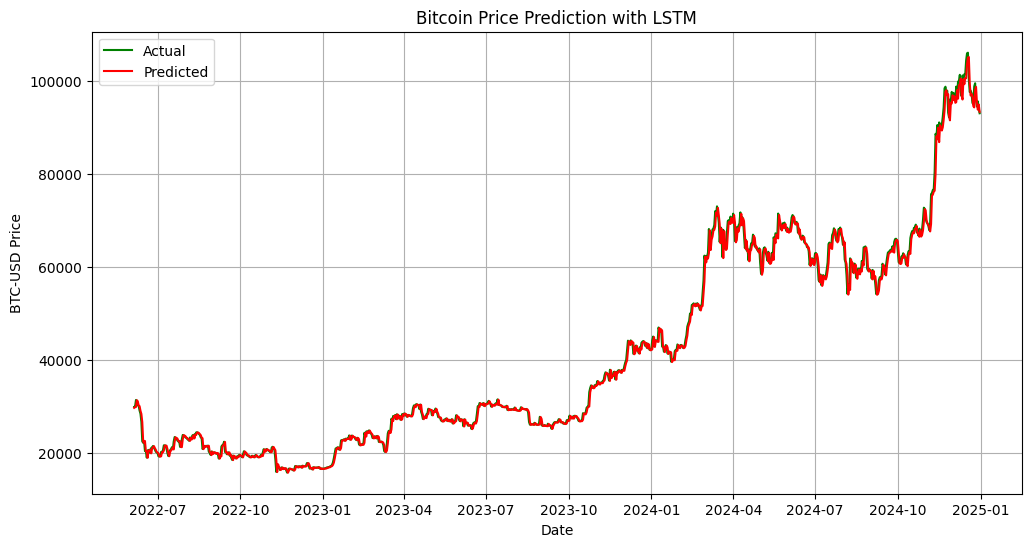

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(data_btc_usd.index[-len(y_test):], y_test, label="Actual", color='g')
plt.plot(data_btc_usd.index[-len(y_test):], y_pred, label="Predicted", color='r')
plt.title("Bitcoin Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("BTC-USD Price")
plt.legend()
plt.grid()
plt.show()

## 📐 Step 11: Evaluate Model Performance

We compute the following evaluation metrics:
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)
- Accuracy = 100 - MAPE

In [39]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Accuracy: {accuracy:.2f}%')


Mean Absolute Error (MAE): 789.1641
Mean Squared Error (MSE): 1642501.1442
Root Mean Squared Error (RMSE): 1281.6010
Mean Absolute Percentage Error (MAPE): 1.85%
Accuracy: 98.15%
